In [11]:
import numpy as np

# Glaso correlation function with optimization parameters
def glaso_correlation(alpha_1, alpha_2, alpha_3, alpha_4, Pb, Tb, gamma_g, API):
    # Ensure pressure is positive to avoid log(0) or negative
    if Pb <= 0:
        raise ValueError("Pressure Pb must be positive")
    
    # Check temperature is above 460 to avoid division by zero
    if Tb <= 460:
        raise ValueError("Temperature Tb must be greater than 460")
    
    # Calculate x based on Pb and other parameters
    try:
        x = ((alpha_3 * API) - (0.00091 * Tb))
    except Exception as e:
        print(f"Error calculating x: {e}")
        x = 0  # Default to 0 if error occurs
    
    # Cap the value of x to avoid extreme results
    x = np.clip(x, -10, 10)
    
    # Estimate Rs using the Glaso formula
    try:
        Rs_estimated = gamma_g * ((((Pb / alpha_1) + (alpha_2)) * (10 ** x)) ** alpha_4)
    except Exception as e:
        print(f"Error calculating Rs: {e}")
        Rs_estimated = 0  # Default to 0 if error occurs
    
    return Rs_estimated

# Objective function for optimization
def objective_function(alpha_1, alpha_2, alpha_3, alpha_4, Pb_data, Tb_data, GOR_data, gamma_g, API):
    predicted_GOR = np.array([glaso_correlation(alpha_1, alpha_2, alpha_3, alpha_4, Pb, Tb, gamma_g, API)
                              for Pb, Tb in zip(Pb_data, Tb_data)])
    
    # Calculate Mean Absolute Error between actual and estimated GOR
    error = np.sum(np.abs(predicted_GOR - GOR_data)) / len(GOR_data)
    return error

# ACO optimization function to find the best parameters
def aco_optimize(Pb_data, Tb_data, GOR_data, gamma_g, API, n_ants=50, n_iterations=5000, alpha=1, beta=2, rho=0.1, Q=100):
    pheromones = np.ones((4, n_ants))  # Initialize pheromones for coefficients
    best_solution = [1.0] * 4  # Initial solution guess
    best_error = float('inf')
    
    # Main optimization loop
    for iteration in range(n_iterations):
        solutions = np.zeros((n_ants, 4))  # Store solutions for each ant
        errors = []

        # Each ant generates a solution and evaluates it
        for ant in range(n_ants):
            # Generate random coefficients based on pheromones, with adjusted bounds
            alpha_1 = np.random.uniform(0, 10) * pheromones[0, ant] ** alpha
            alpha_2 = np.random.uniform(0, 5) * pheromones[1, ant] ** beta
            alpha_3 = np.random.uniform(0, 2) * pheromones[2, ant] ** beta
            alpha_4 = np.random.uniform(0, 5) * pheromones[3, ant] ** beta


            # Calculate error for the current solution
            error = objective_function(alpha_1, alpha_2, alpha_3, alpha_4, Pb_data, Tb_data, GOR_data, gamma_g, API)
            
            # Store the solution and error
            solutions[ant] = [alpha_1, alpha_2, alpha_3, alpha_4]
            errors.append(error)
            
            # Track the best solution so far
            if error < best_error:
                best_error = error
                best_solution = [alpha_1, alpha_2, alpha_3, alpha_4]

        # Update pheromones based on performance
        pheromones *= (1 - rho)  # Pheromone evaporation
        
        # Apply more rewarding pheromone update based on lower error
        for ant in range(n_ants):
            pheromone_update = Q / (errors[ant] + 1e-6)  # Prevent division by zero
            pheromones[:, ant] += pheromone_update

        # Print the best solution for each iteration
        print(f"Iteration {iteration + 1}, Best Error: {best_error}, Coefficients: {best_solution}")
    
    return best_solution, best_error

# Example PVT Data (Bubble Point Pressure, API Gravity, Gas Gravity, Reservoir Temperature, Actual GOR)
pvt_data = [
    {'bubble_point_pressure': 2405, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 520, 'actual_gor': 737},
    {'bubble_point_pressure': 2200, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 520, 'actual_gor': 684},
    {'bubble_point_pressure': 1950, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 520, 'actual_gor': 620},
    {'bubble_point_pressure': 1700, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 520, 'actual_gor': 555},
    {'bubble_point_pressure': 1450, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 520, 'actual_gor': 492},
    {'bubble_point_pressure': 1200, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 520, 'actual_gor': 429},
    {'bubble_point_pressure': 950, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 520, 'actual_gor': 365},
    {'bubble_point_pressure': 700, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 520, 'actual_gor': 301},
    {'bubble_point_pressure': 450, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 520, 'actual_gor': 235},
    {'bubble_point_pressure': 200, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 520, 'actual_gor': 155},
]

# Convert to arrays
Pb_data = np.array([entry['bubble_point_pressure'] for entry in pvt_data])  # Pressure values
Tb_data = np.array([entry['reservoir_temperature'] for entry in pvt_data])   # Temperature values
GOR_data = np.array([entry['actual_gor'] for entry in pvt_data])            # Actual GOR values

# Constants
gamma_g = 0.743   # Gas gravity value (same for all entries in this case)
API = 37.0        # API gravity value (same for all entries in this case)

# Running the ACO optimization
best_solution, best_error = aco_optimize(Pb_data, Tb_data, GOR_data, gamma_g, API)

# Displaying the optimized solution
print(f"Optimized coefficients: alpha_1 = {best_solution[0]}, alpha_2 = {best_solution[1]}, alpha_3 = {best_solution[2]}, "
      f"alpha_4 = {best_solution[3]}")

Iteration 1, Best Error: 437.7913562996317, Coefficients: [5.580532650705568, 0.9091493067365092, 1.9853735366432625, 0.11542436977993731]
Iteration 2, Best Error: 240.54761325231397, Coefficients: [1.8790948265582366, 1.865443846738943, 0.5844713272364062, 0.192964813675269]
Iteration 3, Best Error: 240.54761325231397, Coefficients: [1.8790948265582366, 1.865443846738943, 0.5844713272364062, 0.192964813675269]
Iteration 4, Best Error: 21.391405431353174, Coefficients: [0.13049221428135618, 1.5560371315310653, 0.030572140635740278, 0.6011547017463524]
Iteration 5, Best Error: 21.391405431353174, Coefficients: [0.13049221428135618, 1.5560371315310653, 0.030572140635740278, 0.6011547017463524]
Iteration 6, Best Error: 21.391405431353174, Coefficients: [0.13049221428135618, 1.5560371315310653, 0.030572140635740278, 0.6011547017463524]
Iteration 7, Best Error: 21.391405431353174, Coefficients: [0.13049221428135618, 1.5560371315310653, 0.030572140635740278, 0.6011547017463524]
Iteration 8, 

C:\Users\CALEB\AppData\Local\Temp\ipykernel_18128\3914143075.py:25: RuntimeWarning: overflow encountered in scalar power
  Rs_estimated = gamma_g * ((((Pb / alpha_1) + (alpha_2)) * (10 ** x)) ** alpha_4)


Iteration 93, Best Error: 19.26776962079221, Coefficients: [2.2422523454138865, 0.5797145860850696, 0.060988752507831964, 0.6174758977193301]
Iteration 94, Best Error: 19.26776962079221, Coefficients: [2.2422523454138865, 0.5797145860850696, 0.060988752507831964, 0.6174758977193301]
Iteration 95, Best Error: 19.26776962079221, Coefficients: [2.2422523454138865, 0.5797145860850696, 0.060988752507831964, 0.6174758977193301]
Iteration 96, Best Error: 19.26776962079221, Coefficients: [2.2422523454138865, 0.5797145860850696, 0.060988752507831964, 0.6174758977193301]
Iteration 97, Best Error: 19.26776962079221, Coefficients: [2.2422523454138865, 0.5797145860850696, 0.060988752507831964, 0.6174758977193301]
Iteration 98, Best Error: 19.26776962079221, Coefficients: [2.2422523454138865, 0.5797145860850696, 0.060988752507831964, 0.6174758977193301]
Iteration 99, Best Error: 19.26776962079221, Coefficients: [2.2422523454138865, 0.5797145860850696, 0.060988752507831964, 0.6174758977193301]
Iterat

In [12]:
"""Taking the optimized coefficients a, b, c, d, e, f, g are found in best_solution
# Example: best_solution contains the optimized coefficients from the ACO optimization
# If best_solution is obtained from a previous ACO optimization process:
# best_solution = [best_a, best_b, best_c, best_d, best_e, best_f, best_g]"""

gamma_g = 0.743  # Example value for gas gravity
API = 37         # Example value for API gravity

# Extract each coefficient from best_solution (this should come from the ACO optimization)
best_a, best_b, best_c, best_d = best_solution

# Calculate the optimized GOR values using the complete set of coefficients
optimized_GOR = np.array([glaso_correlation(best_a, best_b, best_c, best_d, Pb, Tb, gamma_g, API)
                          for Pb, Tb in zip(Pb_data, Tb_data)])

print("Optimized GOR values:", optimized_GOR)

Optimized GOR values: [716.7316593  673.2361913  618.5256461  561.68896862 502.3093168
 439.79854606 373.27331143 301.27988917 221.04265897 125.42357613]


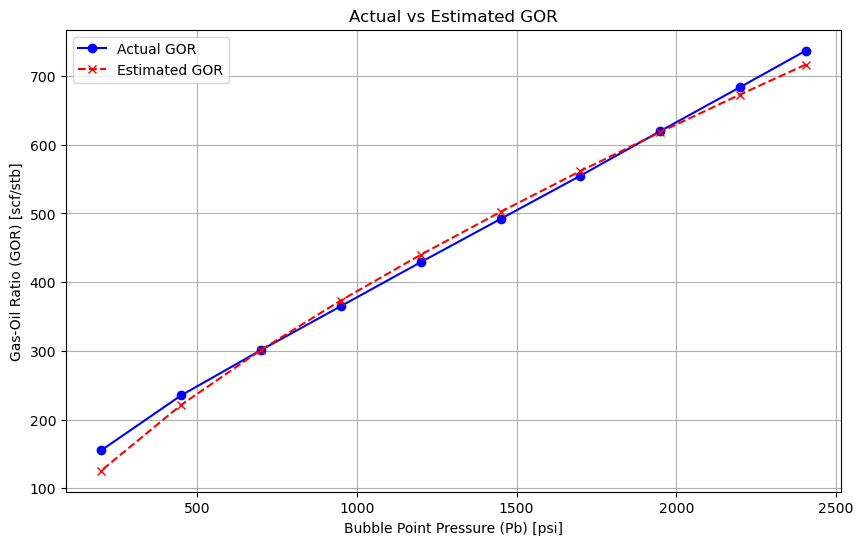

In [13]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(Pb_data, GOR_data, label='Actual GOR', color='b', marker='o', linestyle='-', markersize=6)
plt.plot(Pb_data, optimized_GOR, label='Estimated GOR', color='r', marker='x', linestyle='--', markersize=6)

# Add labels and title
plt.xlabel('Bubble Point Pressure (Pb) [psi]')
plt.ylabel('Gas-Oil Ratio (GOR) [scf/stb]')
plt.title('Actual vs Estimated GOR')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()